# Grids of Multivariate Time Series

## Load libraries and auxiliar functions

In [1]:
import sys
sys.path.append('../')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.sample_tiles import *
from time import time
from torch.autograd import Variable
from src.aux_functions import *
from src.tilenet import make_tilenet
from src.resnet import ResNet18

In [4]:
pwd

'/home/carlos.echegoyen/Research/clustering_tile2vec/unsupervised-semantic-analysis/experiments'

## Load the model

In this example, we encode the sequences of tiles with the geographic based embedding, $f^g$, trained for the paper. We also provide the clustering-based embedding $f^c$ of the paper, which could be used here to create the corresponding collection of MTS in the same way.

In [2]:
# Setting up model
in_channels = 3
z_dim = 512
tilenet = make_tilenet(in_channels=in_channels, z_dim=z_dim)

In [5]:
# Load model
model = '../models/TileNet_epoch50_512_100_100K_sentinel.ckpt'
checkpoint = torch.load(model)
tilenet.load_state_dict(checkpoint)
tilenet.eval()

TileNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

## Generate and save the grids of MTS

Repeat the procedure for each region of interest under study. We provide an example with an area called 'NE-TXN'

In [8]:
area = 'NE-TXN'
data_dir = '../data'
data_dir =  os.path.join(data_dir, area)

# Directory with the sequenes of tiles
tile_dir = os.path.join(data_dir, "tiles")
img_ext = '.tif'

if not os.path.exists(tile_dir):
    os.makedirs(tile_dir)

tile_size = 100
size_even = (tile_size % 2 == 0)
tile_radius = tile_size // 2

# This size depends on the tile size and the image size in pixels
n_samples = 110*110
# Number of images of the sequence
n_elems = 3

Create, encode and save the sequences of tiles associated to the sequence of images. The original sequences of tiles can also be saved.

In [ ]:
X = np.zeros((n_samples, n_elems, z_dim))
save_tiles = True

cont_t = 0
for filename in sorted(os.listdir(data_dir)):
    # Load image
    filename
    if filename.endswith(img_ext):
        img = load_img(os.path.join(data_dir, filename), val_type='uint8', bands_only=True)
        img = np.pad(img, pad_width=[(tile_radius, tile_radius),
                                            (tile_radius, tile_radius), (0, 0)], mode='reflect')
        cont_s = 0
        # For each tile in the grid of the given image
        for i in range(0, img.shape[0] // tile_size):
            for j in range(0, img.shape[1] // tile_size):
                start_r = i*tile_size
                end_r = (i+1)*tile_size
                start_c = j*tile_size
                end_c = (j+1)*tile_size
                # Save tile according to the time and number
                if save_tiles:
                    save_as = os.path.join(tile_dir, '{sample}tile_T{t}.npy'.format(sample=cont_s, t=cont_t))
                    np.save(save_as, img[start_r:end_r,start_c:end_c,:])
                # Create embedded vector
                tile = np.moveaxis(img[start_r:end_r,start_c:end_c,:], -1, 0)
                tile= np.expand_dims(tile, axis=0)
                tile = tile / 255
                 # Embed tile
                z = torch.from_numpy(tile).float()
                z = Variable(z)
                z = tilenet.encode(z)
                z = z.data.numpy()
                X[cont_s, cont_t, :] = z
                # Increase the count of samples within the image
                cont_s = cont_s + 1
        # Increase the time
        cont_t = cont_t + 1

Save the numpy array with the whole collection of multivariate time series encoded by the model. We can have two collections, one for each model $f^g$ and $f^c$.

In [10]:
# Save MTS encoded
res_dir = os.path.join(data_dir, "MTS")
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
res_dir = os.path.join(res_dir, 'X_epoch50_512_100_100K_' + area + '.npy')
np.save(res_dir, X)

Compute and save the matrix of distances between time series for further experiments

In [ ]:
Dist_mat = dist_mat_ts(X, n_samples)
np.save('distances_NE-TXN', Dist_mat)

## Plot sequences of tiles

Illustrative example of 10 randomly selected sequences of tiles. This code can only be run if the tiles generated before have been saved.

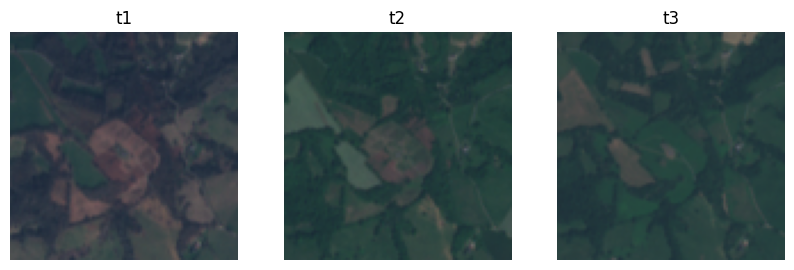

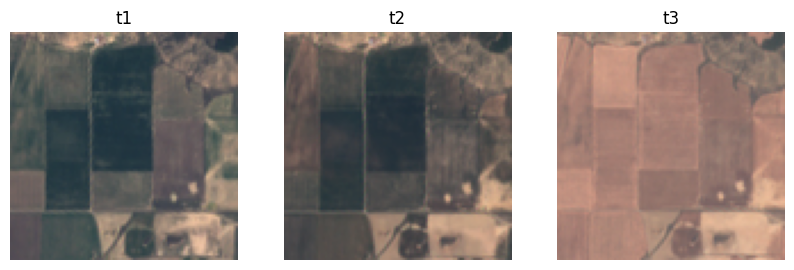

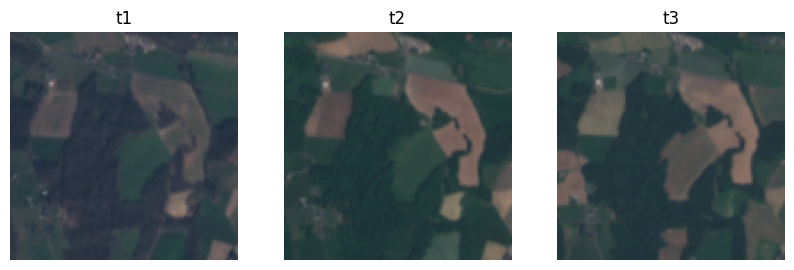

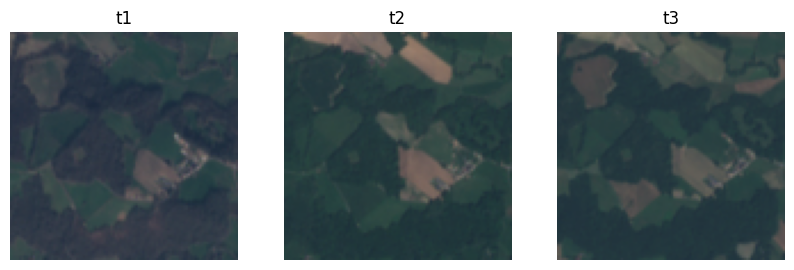

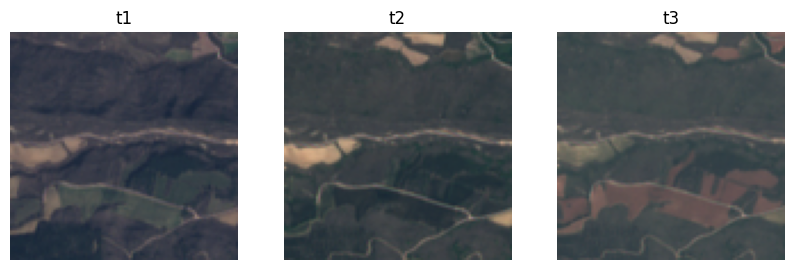

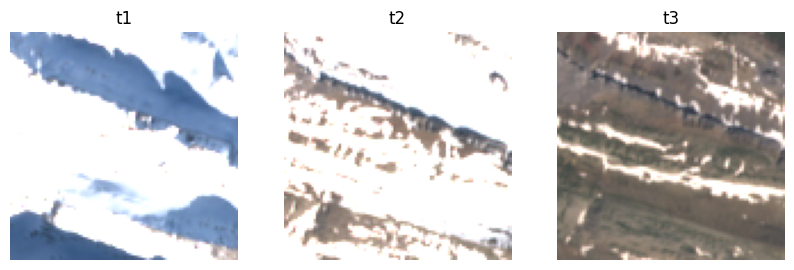

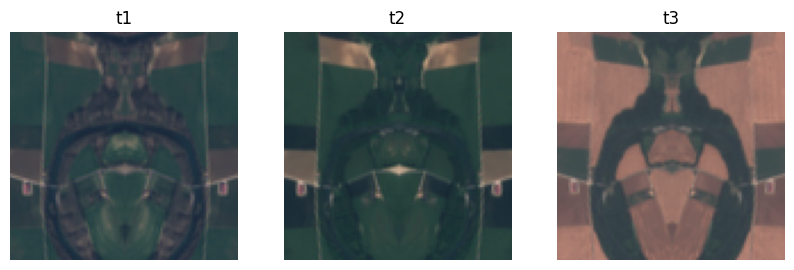

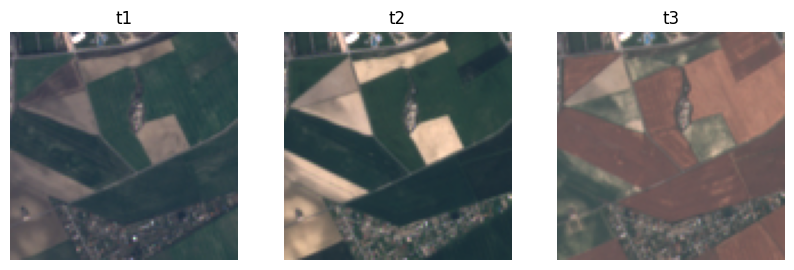

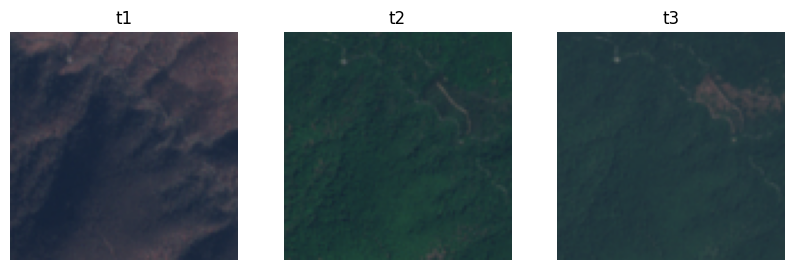

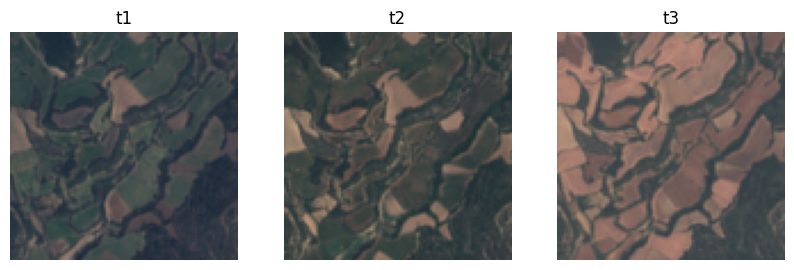

In [26]:
import random
n_st = 10
iST = random.sample(range(n_samples), n_st)
for i in iST:
    Plot_TS_long(i, 3, tile_dir)